# JSON files for d3 visualization

In [573]:
import os
import copy
import json
import numpy as np
import matplotlib.pyplot as plt

In [460]:
with open('./data/b0.json') as infile:
    data = json.load(infile)

In [446]:
data.keys()

dict_keys(['frame_index', 'input_values', 'layers', 'rts'])

In [462]:
start = data['rts'][0][0]

In [463]:
start.keys()

dict_keys(['activation_value', 'children', 'coordinates', 'global_coordinates', 'layer', 'node', 'raw_value', 'relevance_value', 'size', 'strides', 'weights'])

In [470]:
for key in start:
    if key != 'children' and key != 'weights':
        print(key, start[key])

activation_value 0.5342745780944824
coordinates [0, 6, 3, 0]
global_coordinates [0, 65.5, 41.5, 0]
layer Tensor (not serialized)
node Tensor (not serialized)
raw_value -0.4884624779224396
relevance_value 0.5342745780944824
size 1
strides 1


## Attention squares

In [590]:
!ls data/

b0.json  b11.json b14.json b17.json b3.json  b6.json  b9.json
b1.json  b12.json b15.json b18.json b4.json  b7.json  old
b10.json b13.json b16.json b2.json  b5.json  b8.json


In [624]:
len(data['rts'][0])

4

In [656]:
trees = []
json_files = [f for f in os.listdir('./data') if f.endswith('.json')]
for n in range(len(json_files)):

    with open(f'./data/b{n}.json') as infile:
        data = json.load(infile)
        
    metadata = {
        'children': data['rts'][0],
        'global_coordinates': [0,0,0,0],
        'coordinates': [0,0,0,0],
        'relevance_value': 1
    }

    tree = metadata # data['rts'][0][0]

    # field_sizes = [geom['global_size'] for geom in data['layer_geometries']]
    field_sizes = [8, 20, 36, 36, 36, 0]
    # field_sizes

    # kernel_sizes = [geom['size'] for geom in data['layer_geometries']]
    # kernel_sizes

    def clean(dictionary):
        """Only keep some keys in the nested dictionary."""

        for key in list(dictionary):
            if key not in ['children', 'global_coordinates', 'coordinates', 'relevance_value']:
                del dictionary[key]
            else:
                if isinstance(dictionary[key], list):
                    try:
                        if isinstance(dictionary[key][0], dict):
                            for child in dictionary[key]:
                                clean(child)
                    except IndexError:
                        pass

    clean(tree)

    # def name(dictionary, layer):
    #     """Add a layer name to all dictionaries in the nested dictionary."""

    #     dictionary['name'] = f'layer_{layer}'

    #     for key in list(dictionary):
    #         if isinstance(dictionary[key], list):
    #             try:
    #                 if isinstance(dictionary[key][0], dict):
    #                     for child in dictionary[key]:
    #                         name(child, layer-1)
    #             except IndexError:
    #                 pass

    # name(tree, layer=5)

    def get_coordinates(node, depth):

        n_layers = 6

        x, y = node['global_coordinates'][1:3]
        size = field_sizes[-(depth + 1)]

        layer = n_layers - depth
        if layer <= 3:
            letter = 'C'
            number = str(layer)
        elif layer > 3 and layer < 6:
            letter = 'A'
            number = str(layer - 3)
        elif layer == 6:
            letter = 'Start'
            number = ''

        node['layer'] = layer
        node['square'] =  (x, y, size)  # center x, center y, height/width
        node['name'] = letter + number
        if layer != 6 :
            node['name'] += ' (' + ', '.join([str(n) for n in node['coordinates'][1:]]) + ')'

        for child in node['children']:
            get_coordinates(node=child, depth=depth+1)

    get_coordinates(tree, depth=0)
    
    
    def colorize(node, branch=None):
            
        if branch == None:
            color = 'black'
        elif branch == 1:
            color = 'red'
        elif branch == 2:
            color = 'red'
        elif branch == 3:
            color = 'yellow'
        elif branch == 4:
            color = 'yellow'
            
        node['color'] = color
        
        for i, child in enumerate(node['children']):
            if branch == None:
                lower_branch = i+1
            else:
                lower_branch = branch
            colorize(child, branch=lower_branch)
            
    colorize(tree)

    # def truncate(node, factor=2):

    #     n_children = len(node['children'])
    #     n_truncated = int(n_children/factor)

    #     if n_children > 0:
    #         node['children'] = node['children'][0:n_truncated]
    #         for child in node['children']:
    #             truncate(child)

    # temp = copy.deepcopy(tree)
    # truncate(temp)

    def pick(node, depth):

        n_children = len(node['children'])
        if n_children > 1:

            n_layers = 6
            layer = n_layers - depth
            mapping = {
                6: None,
                5: 1,
                4: 1,
                3: 1,
                2: 1,
                1: 0
            }
            n_max = mapping[layer]
            
            node['children'] = node['children'][0:n_max]

            for child in node['children']:
                pick(child, depth=depth+1)

    pick(tree, depth=0)
    
    trees.append(tree)
            

with open('trees.json', 'w') as outfile:
    json.dump(trees, outfile)

# Game background

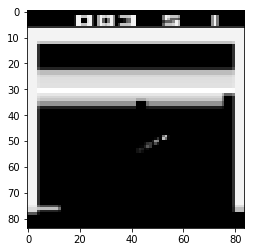

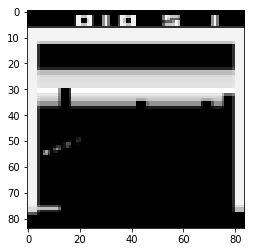

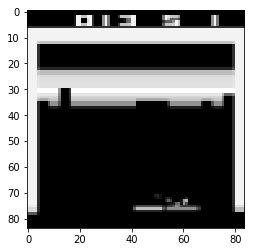

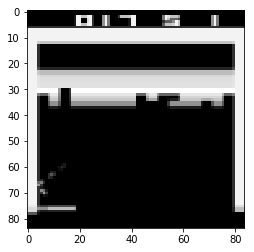

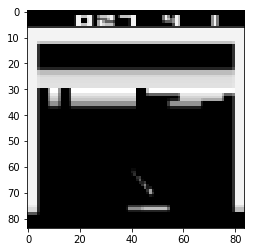

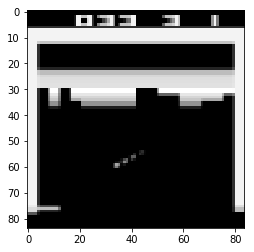

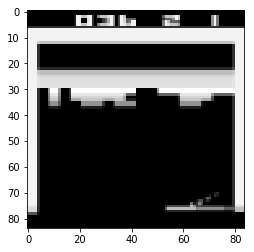

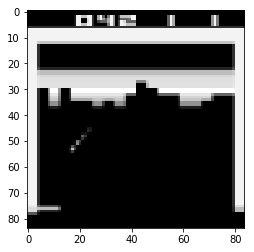

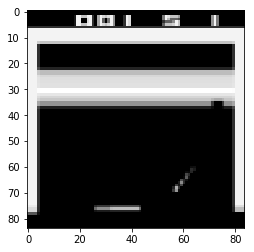

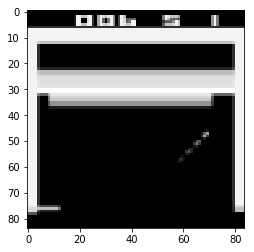

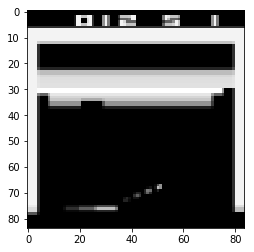

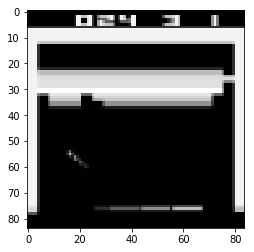

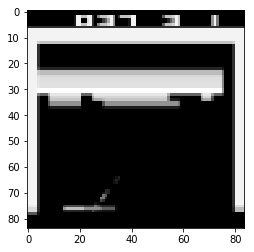

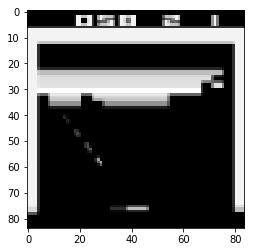

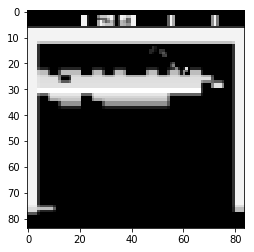

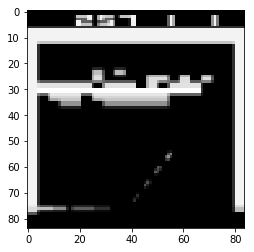

In [598]:
screens = []
overlays = []

json_files = [f for f in os.listdir('./data') if f.endswith('.json')]
for n in range(len(json_files)):
    
    with open(f'./data/b{n}.json') as infile:
        data = json.load(infile)

    tensor = np.asarray(data['input_values'], dtype=np.int)
    n_frames = tensor.shape[-1]

    for frame in range(n_frames):
        tensor[:, :, :, frame] = tensor[:, :, :, frame] * (n_frames - frame)
            # assuming that the last frame is the latest in time

    overlay = np.squeeze(np.amax(tensor, axis=-1))
    overlay = overlay / overlay.max() * 255
    overlay = overlay.astype(np.int)
    
    overlays.append(overlay)

    pixels = []
    for y, row in enumerate(overlay):
        for x, value in enumerate(row):
            pixels.append({
                'x': int(x),
                'y': int(y),
                'value': int(value)
            })
            
    screens.append(pixels)

with open('screens.json', 'w') as outfile:
    json.dump(screens, outfile)

for overlay in overlays:
    plt.imshow(overlay, cmap='gray')
    plt.show()